<a href="https://colab.research.google.com/github/ancelik/booth-cf/blob/main/LendingClub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install openpyxl

In [1]:
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Read the xlsx file into a pandas DataFrame
lendingClubData = pd.read_excel('Data\LC data.xlsx', engine='openpyxl')

# Now you can work with the data in the DataFrame 'df'
print(lendingClubData.head())

<>:2: SyntaxWarning: invalid escape sequence '\L'
<>:2: SyntaxWarning: invalid escape sequence '\L'
C:\Users\AnilCelik\AppData\Local\Temp\ipykernel_26112\2722033958.py:2: SyntaxWarning: invalid escape sequence '\L'
  lendingClubData = pd.read_excel('Data\LC data.xlsx', engine='openpyxl')


         id  loan_amnt        term  int_rate grade sub_grade  \
0  76003542      16000   36 months    0.0532     A        A1   
1  76023477      17000   36 months    0.0975     B        B3   
2  75993535      15000   60 months    0.1531     C        C5   
3  73458582       2425   36 months    0.1531     C        C5   
4  73511090      29900   36 months    0.1299     C        C2   

              emp_title emp_length home_ownership  annual_inc  ...  \
0  Security specialist     8 years           RENT    105000.0  ...   
1  Kindergarten Teacher   < 1 year       MORTGAGE     40000.0  ...   
2        Branch Manager  10+ years       MORTGAGE     70000.0  ...   
3               Teacher    5 years       MORTGAGE     25000.0  ...   
4        Executive Chef  10+ years       MORTGAGE     68000.0  ...   

  total_bal_il bc_util mths_since_recent_revol_delinq total_bal_ex_mort  \
0      17306.0    29.7                            9.0             23525   
1      17930.0    85.9                      

In [3]:
lendingClubData.head(5)

,id,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,total_bal_il,bc_util,mths_since_recent_revol_delinq,total_bal_ex_mort,total_bc_limit,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,loan_status,most_recent_fico
0,76003542,16000,36 months,0.0532,A,A1,Security specialist,8 years,RENT,105000.0,...,17306.0,29.7,9.0,23525,19400,2016-05-01,16107.80,NaT,Fully Paid,679
1,76023477,17000,36 months,0.0975,B,B3,Kindergarten Teacher,< 1 year,MORTGAGE,40000.0,...,17930.0,85.9,NaN,31939,16300,2017-11-01,546.55,2017-12-01,Current,799
2,75993535,15000,60 months,0.1531,C,C5,Branch Manager,10+ years,MORTGAGE,70000.0,...,15692.0,38.7,NaN,27322,16000,2017-04-01,13106.47,NaT,Fully Paid,754
3,73458582,2425,36 months,0.1531,C,C5,Teacher,5 years,MORTGAGE,25000.0,...,15963.0,99.8,NaN,26567,7300,2016-12-01,2062.67,NaT,Fully Paid,714
4,73511090,29900,36 months,0.1299,C,C2,Executive Chef,10+ years,MORTGAGE,68000.0,...,10861.0,91.1,NaN,24845,7900,2017-09-01,1007.31,2017-12-01,Late (31-120 days),604


In [4]:
#Feature Engineering

#NEW FEATURES 1: 
# Create the 'lowerCaseEmpTitle' column
lendingClubData['lowerCaseEmpTitle'] = lendingClubData['emp_title'].astype(str).str[0].str.islower().astype(int)

#NEW FEATURES 2:
# One-hot encode the specified columns
purpose_encoded = pd.get_dummies(lendingClubData['purpose'], prefix='purpose')
emp_length_encoded = pd.get_dummies(lendingClubData['emp_length'], prefix='emp_length')
home_ownership_encoded = pd.get_dummies(lendingClubData['home_ownership'], prefix='home_ownership')
verification_encoded = pd.get_dummies(lendingClubData['verification_status'], prefix='verification')
addr_state_encoded = pd.get_dummies(lendingClubData['addr_state'], prefix='addr_state')

# If 'dti' is categorical, one-hot encode it as well
# dti_encoded = pd.get_dummies(df['dti'], prefix='dti')  # Uncomment if 'dti' is categorical

# Convert boolean to integer (0 or 1) - usually not necessary, but ensures integer type
purpose_encoded = purpose_encoded.astype(int)
emp_length_encoded = emp_length_encoded.astype(int)
home_ownership_encoded = home_ownership_encoded.astype(int)
verification_encoded = verification_encoded.astype(int)
addr_state_encoded = addr_state_encoded.astype(int)
# dti_encoded = dti_encoded.astype(int)  # Uncomment if 'dti' is categorical

# Concatenate the new one-hot encoded columns to the original DataFrame
lendingClubData = pd.concat([lendingClubData, purpose_encoded, emp_length_encoded, home_ownership_encoded, verification_encoded, addr_state_encoded], axis=1)


In [5]:
lendingClubData.head(5)

,id,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,76003542,16000,36 months,0.0532,A,A1,Security specialist,8 years,RENT,105000.0,...,0,0,0,0,0,0,0,0,0,0
1,76023477,17000,36 months,0.0975,B,B3,Kindergarten Teacher,< 1 year,MORTGAGE,40000.0,...,0,0,0,0,0,0,0,0,0,0
2,75993535,15000,60 months,0.1531,C,C5,Branch Manager,10+ years,MORTGAGE,70000.0,...,0,0,1,0,0,0,0,0,0,0
3,73458582,2425,36 months,0.1531,C,C5,Teacher,5 years,MORTGAGE,25000.0,...,0,0,0,0,0,0,0,0,0,0
4,73511090,29900,36 months,0.1299,C,C2,Executive Chef,10+ years,MORTGAGE,68000.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#PART-B QUESTION 1
# Create a new data field (i.e., a new column) called default that is equal to 1 whenever
# loan_status is equal to “Late (31-120 days)” or “Charged Off,” and otherwise is equal
# to 0. What is the average of this new variable, default? What does that average tell you?

lendingClubData['default'] = lendingClubData['loan_status'].apply(lambda x: 1 if x in ['Late (31-120 days)', 'Charged Off'] else 0)
lendingClubData.head(5)

lendingClubData['default'].mean()


np.float64(0.12099755764189205)

## This tells us that 12.09% of the borrowers either defaulted or were late on their loans.


In [7]:
#PART-B QUESTION 2
#We’ll call borrowers for whom default=1 “bads” and borrowers for whom default=0“goods.” 
# What share of goods listed “debt_consolidation” as their loan purpose? 
# Does this mean that listing debt consolidation predicts a borrower will be a good?

goods = lendingClubData[lendingClubData['default'] == 0]
debt_consolidation_goods = goods[goods['purpose'] == 'debt_consolidation']

# Calculate the share of goods with 'debt_consolidation' as their loan purpose
share_of_goods = len(debt_consolidation_goods) / len(goods)
share_of_goods

0.5674628463636595

# 56.7% of the goods listed debt consolidation as their loan purpose.


In [8]:
bads = lendingClubData[lendingClubData['default'] == 1]
debt_consolidation_bads = bads[bads['purpose'] == 'debt_consolidation']

# Calculate the share of goods with 'debt_consolidation' as their loan purpose
share_of_bads = len(debt_consolidation_bads) / len(bads)
share_of_bads

0.611358024691358

# 61.1% of the bads listed debt consolidation as their loan purpose.

# 56.7% of the goods listed debt consolidation as their loan purpose.
# 61.1% of the bads listed debt consolidation as their loan purpose.

# Listing debt consolidation as your loan purpose does not necessarily predict a borrower will be a good or bad as the share of debt consolidation loans is very similar for both goods and bads. 

In [12]:
# Select only the numeric columns
numeric_df = lendingClubData.select_dtypes(include=['number'])

# Display the first few rows of the new DataFrame to verify
print(numeric_df.head())


         id  loan_amnt  int_rate  annual_inc    dti  delinq_2yrs  fico  \
0  76003542      16000    0.0532    105000.0  15.02            1   720   
1  76023477      17000    0.0975     40000.0  24.30            0   705   
2  75993535      15000    0.1531     70000.0   9.99            0   690   
3  73458582       2425    0.1531     25000.0  38.50            0   705   
4  73511090      29900    0.1299     68000.0  17.49            0   675   

   inq_last_6mths  mths_since_last_delinq  open_acc  ...  addr_state_TN  \
0             0.0                     9.0         9  ...              0   
1             0.0                     NaN         4  ...              0   
2             0.0                    32.0         6  ...              0   
3             0.0                     NaN         7  ...              0   
4             2.0                     NaN        14  ...              0   

   addr_state_TX  addr_state_UT  addr_state_VA  addr_state_VT  addr_state_WA  \
0              0        

Correlation of 'default' with other numeric fields:
default                      1.000000
int_rate                     0.243844
dti                          0.083990
inq_last_6mths               0.083657
verification_Verified        0.079878
                               ...   
total_bc_limit              -0.072141
verification_Not Verified   -0.079229
fico                        -0.112249
last_pymnt_amnt             -0.162571
most_recent_fico            -0.643072
Name: default, Length: 103, dtype: float64


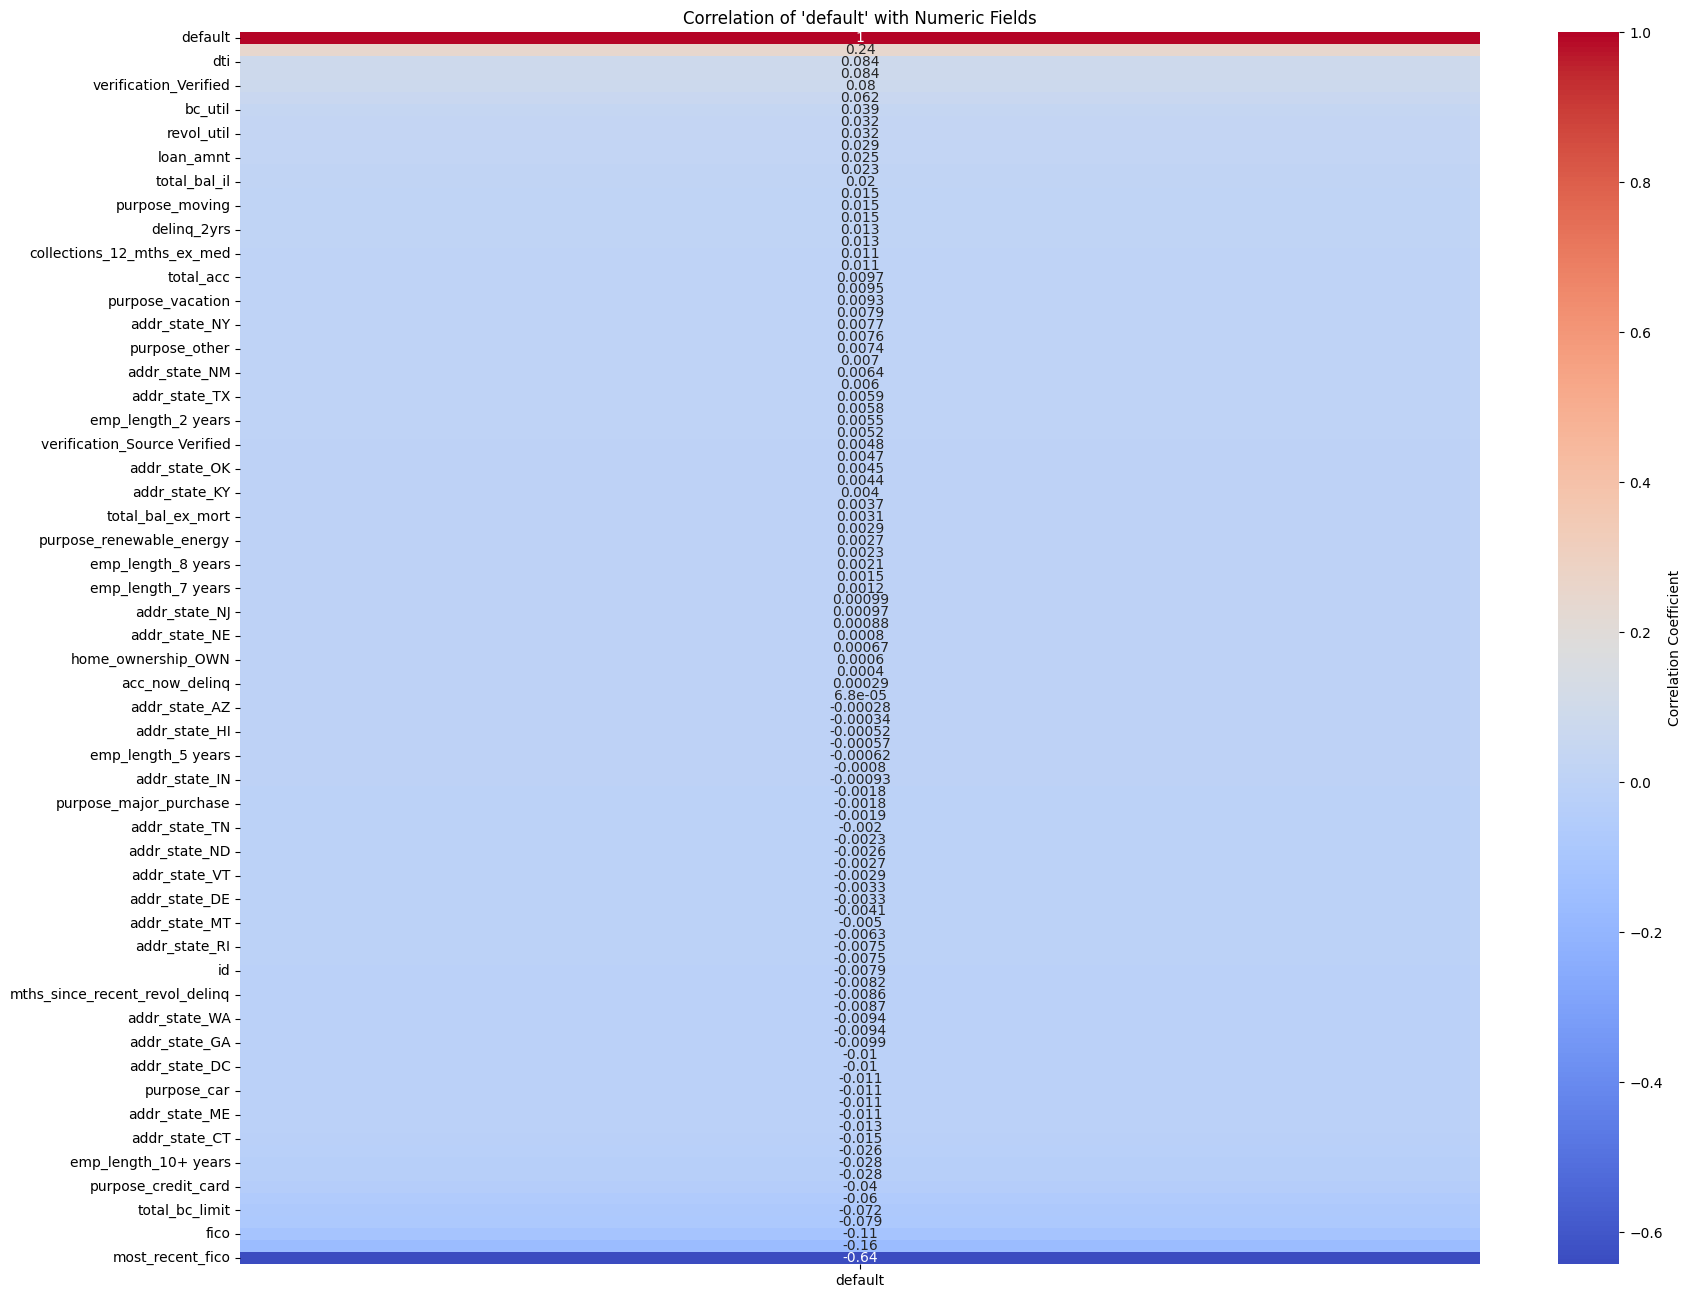

Correlation of each feature with 'default':
           Feature  Correlation
0               id    -0.007921
1        loan_amnt     0.025285
2         int_rate     0.243844
3       annual_inc    -0.026362
4              dti     0.083990
..             ...          ...
98   addr_state_WA    -0.009417
99   addr_state_WI    -0.010748
100  addr_state_WV    -0.000573
101  addr_state_WY     0.000399
102        default     1.000000

[103 rows x 2 columns]


In [34]:
# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Extract the correlation of 'default' with all other numeric fields
default_correlation = correlation_matrix['default'].sort_values(ascending=False)

# Print the correlation values
print("Correlation of 'default' with other numeric fields:")
print(default_correlation)

# Visualize the correlation of 'default' with other numeric fields using a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix[['default']].sort_values(by='default', ascending=False), annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation of 'default' with Numeric Fields")
plt.show()

# Extract the correlation of 'default' with all other numeric fields
default_correlation = correlation_matrix['default']

# Convert the default_correlation series into a DataFrame
default_correlation_df = pd.DataFrame(default_correlation).reset_index()
default_correlation_df.columns = ['Feature', 'Correlation']

# Display the DataFrame
print("Correlation of each feature with 'default':")
print(default_correlation_df)

In [43]:
default_correlation_df['abs_correlation'] = default_correlation_df['Correlation'].abs()
default_correlation_df.sort_values(by='abs_correlation', ascending=False).head(10)


,Feature,Correlation,abs_correlation
102,default,1.000000,1.000000
21,most_recent_fico,-0.643072,0.643072
2,int_rate,0.243844,0.243844
20,last_pymnt_amnt,-0.162571,0.162571
6,fico,-0.112249,0.112249
4,dti,0.083990,0.083990
7,inq_last_6mths,0.083657,0.083657
51,verification_Verified,0.079878,0.079878
49,verification_Not Verified,-0.079229,0.079229
19,total_bc_limit,-0.072141,0.072141


In [44]:
#Since we cannot use default as a feature, we can use the features with the highest correlation to default.
#I will pick, most_recent_fico, fico, dti, inq_last_6mths


In [48]:
pip install scikit-learn


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 11.1/11.1 MB 86.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [52]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df is your DataFrame and it contains the necessary columns

# Define the features and target variable
features = ['most_recent_fico', 'fico', 'dti', 'inq_last_6mths']
X = numeric_df[features]
y = numeric_df['default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set the parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
model = lgb.train(params, train_data, num_boost_round=200, valid_sets=[test_data])

# Make predictions on the test data
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 107109, number of used features: 4
[LightGBM] [Info] Start training from score 0.120653
Mean Squared Error: 0.045141672357294486
R-squared: 0.5796886334532659


Feature importances:
            Feature  Importance
2               dti        2360
0  most_recent_fico        1846
1              fico        1281
3    inq_last_6mths         513


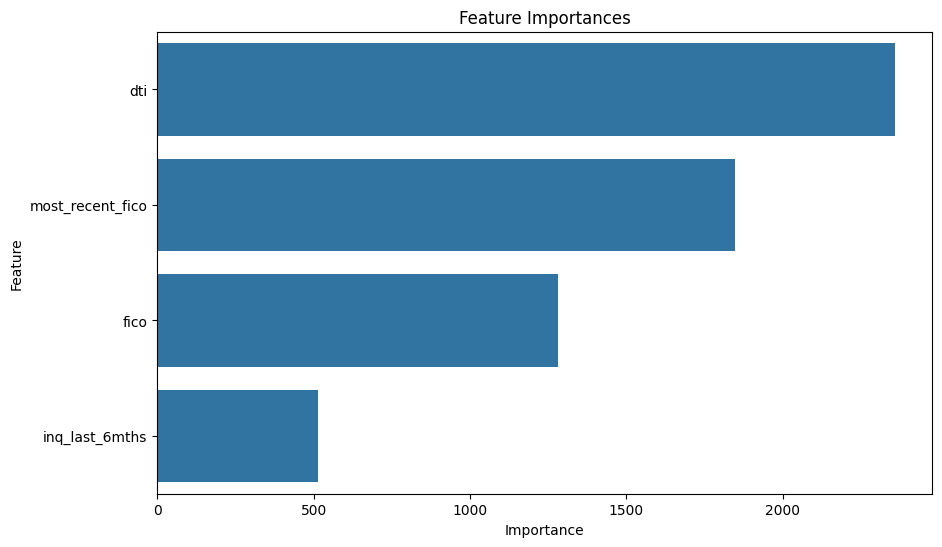

In [53]:
# Get feature importances
feature_importances = model.feature_importance()
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature importances:")
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()